In [4]:
#!/usr/bin/env python
#HIDDEN
import github3, json, os.path, datetime


In [5]:
#HIDDEN
GITHUB_TOKEN = '6230377909c68e26dca13fd9613ee74bb7496aba'
ORG = 'awslabs'

WEBRTC_REPOS = ['amazon-kinesis-video-streams-webrtc-sdk-c', 
                'amazon-kinesis-video-streams-webrtc-sdk-ios', 
                'amazon-kinesis-video-streams-webrtc-sdk-android']
PRODUCER_REPOS = ['amazon-kinesis-video-streams-producer-sdk-cpp', 
                  'amazon-kinesis-video-streams-producer-c', 
                  'amazon-kinesis-video-streams-producer-sdk-java', 
                  'amazon-kinesis-video-streams-pic']
FILENAME_WEBRTC_ISSUES = 'WebRTC_issues.json'
FILENAME_PRODUCER_ISSUES = 'Producer_issues.json'

In [6]:
#HIDDEN
#gh = github3.login(token=GITHUB_TOKEN)
gh = github3.login()
#print(gh)

In [7]:
#HIDDEN
def get_issues(REPOS, FILENAME):
    data = {}
    #if os.path.isfile(FILENAME):
    #    f = open(FILENAME_WEBRTC_ISSUES)
    #    data = json.load(f)
    #    f.close()
        
    for REPO in REPOS:
        print(REPO)
        data[REPO] = {}
        for i in gh.issues_on(ORG, REPO, state='all'):
            data[REPO][i.number] = {
                'created_at': i.created_at,
                'closed_at': i.closed_at,
                'is_pull_request': (i.pull_request is not None)
            }
            
    f = open(FILENAME, 'w')
    json.dump(data, f, cls=DateTimeEncoder)
    f.close()

In [7]:
#HIDDEN
def get_issues(REPOS, FILENAME):
    data = {}
    #if os.path.isfile(FILENAME):
    #    f = open(FILENAME_WEBRTC_ISSUES)
    #    data = json.load(f)
    #    f.close()
        
    for REPO in REPOS:
        print(REPO)
        data[REPO] = {}
        for i in gh.issues_on(ORG, REPO, state='all'):
            data[REPO][i.number] = {
                'created_at': i.created_at,
                'closed_at': i.closed_at,
                'is_pull_request': (i.pull_request is not None)
            }
            
    f = open(FILENAME, 'w')
    json.dump(data, f, cls=DateTimeEncoder)
    f.close()
class DateTimeEncoder(json.JSONEncoder):
  def default(self, obj):
    if isinstance(obj, datetime.datetime):
      return obj.isoformat()
    elif isinstance(obj, datetime.date):
      return obj.isoformat()
    elif isinstance(obj, datetime.timedelta):
      return (datetime.datetime.min + obj).time().isoformat()
    else:
      return super(DateTimeEncoder, self).default(obj)
def extract_datetime(s):
  if isinstance(s, datetime.datetime):
    return s
  return datetime.datetime.strptime(s[:-3] + s[-2:], '%Y-%m-%dT%H:%M:%S%z')

In [8]:
#HIDDEN
get_issues(WEBRTC_REPOS, FILENAME_WEBRTC_ISSUES)      

amazon-kinesis-video-streams-webrtc-sdk-c
amazon-kinesis-video-streams-webrtc-sdk-ios
amazon-kinesis-video-streams-webrtc-sdk-android


In [9]:
#HIDDEN
get_issues(PRODUCER_REPOS, FILENAME_PRODUCER_ISSUES)

amazon-kinesis-video-streams-producer-sdk-cpp
amazon-kinesis-video-streams-producer-c
amazon-kinesis-video-streams-producer-sdk-java
amazon-kinesis-video-streams-pic


In [23]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

#HIDDEN
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

import json, datetime

# tweak here the names of the github org and repo to analyse
ORG = 'awslabs'
WEBRTC_REPOS = ['amazon-kinesis-video-streams-webrtc-sdk-c', 
                'amazon-kinesis-video-streams-webrtc-sdk-ios', 
                'amazon-kinesis-video-streams-webrtc-sdk-android']
PRODUCER_REPOS = ['amazon-kinesis-video-streams-producer-sdk-cpp', 
                  'amazon-kinesis-video-streams-producer-c', 
                  'amazon-kinesis-video-streams-producer-sdk-java', 
                  'amazon-kinesis-video-streams-pic']
FILENAME_WEBRTC_ISSUES = 'WebRTC_issues.json'
FILENAME_PRODUCER_ISSUES = 'Producer_issues.json'

FILENAME_WEBRTC_COUNTS = 'WebRTC_counts.csv'
FILENAME_PRODUCER_COUNTS = 'Producer_counts.csv'



#BUG_LABEL = ['bug']

one_day = datetime.timedelta(days=1)
now = datetime.datetime.now(datetime.timezone.utc)


In [25]:
#HIDDEN
def load_file(FILENAME):
    with open(FILENAME, encoding='utf-8', errors='ignore') as json_data:
        data = json.load(json_data, strict=False)
    return data

In [29]:
#HIDDEN
def get_first_date(REPOS, data):
    first_dates = []
    for REPO in REPOS:
        if REPO not in data.keys() and len(data[REPO]) == 0:
            raise SystemExit()

        # convert all date strings to datetime objects
        for i in data[REPO].keys():
            data[REPO][i]['created_at'] = extract_datetime(data[REPO][i]['created_at'])
            if data[REPO][i]['closed_at'] is not None:
                data[REPO][i]['closed_at'] = extract_datetime(data[REPO][i]['closed_at'])

        # retrieve highest issue number
        last_number = min([int(i) for i in data[REPO].keys()])
        first_dates.append(extract_datetime(data[REPO][str(last_number)]['created_at']))    
        
    first_date = datetime.date.today()
    #print(first)
    for date in first_dates:
        day = date.date()
        if (day < first_date):
            first_date = day

    return first_date
        

In [30]:
#HIDDEN
def get_results(REPOS, FILENAME_ISSUES, FILENAME_COUNTS):
    
    data = load_file(FILENAME_ISSUES)
    
    first_date = get_first_date(REPOS, data)
    print(first_date)
    
    day = datetime.datetime(first_date.year, first_date.month, first_date.day, tzinfo=datetime.timezone.utc)
    day += one_day

    result = {}

    f = open(FILENAME_COUNTS, 'w')
    f.write('date, total_issues, open_issues, closed_issue, open_prs, closed_prs, ranking')
    #f.write('date\topen_issues\tclosed_issues\topen_prs\tclosed_prs\tranking\t%s\n'%'\t'.join(APP_LABEL))
    
    while day < now:
        key = day.strftime('%Y-%m-%d')
        #print(key)

        open_pr_count = 0
        closed_pr_count = 0
        open_issue_count = 0
        closed_issue_count = 0
        total_issue_count = 0
        rating_number = 0
        rating_apps = {}

        for REPO in REPOS:   
            for i in data[REPO]:
                element = data[REPO][i]

                if element['created_at'] > day:
                    continue

                #print(element)
                is_open = True
                total_issue_count += 1
                if isinstance(element['closed_at'], datetime.datetime) and element['closed_at'] < day:
                    is_open = False
                    closed_issue_count += 1
                else: 
                    open_issue_count += 1


        output = '%s,%i,%i,%i,%i,%i'%(key, total_issue_count, open_issue_count, closed_issue_count, open_pr_count, closed_pr_count)
        #print(output)
        f.write(output + '\n')

        day += one_day

    f.close()

In [31]:
#HIDDEN
get_results(PRODUCER_REPOS, FILENAME_PRODUCER_ISSUES, FILENAME_PRODUCER_COUNTS)
     

2017-11-29


In [32]:
#HIDDEN
get_results(WEBRTC_REPOS, FILENAME_WEBRTC_ISSUES, FILENAME_WEBRTC_COUNTS)    

2019-11-26


In [33]:
#HIDDEN
import pandas as pd 
import numpy as np

In [34]:
#HIDDEN
def get_df(FILENAME):
    df=pd.read_csv(FILENAME, parse_dates = ['date'])
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    df.rename(columns = {' total_issues':'total_issues', ' open_issues':'open_issues', 
                                  ' closed_issue':'closed_issues'}, inplace = True) 
    df = df.filter(['date','total_issues','open_issues','closed_issues'])
    
    idx = pd.date_range(df.index[0], df.index[-1])
    df = df.reindex(idx, fill_value=0)
    df['Month_End'] = df.index.is_month_end
    sample_df = df[df['Month_End'] == 1].copy()
    sample_df = sample_df.drop(['Month_End'], axis=1)
    
    sLength = len(sample_df['total_issues'])
    #print(sLength)
    issues_opened =  pd.Series(np.zeros(sLength))
    issues_closed =  pd.Series(np.zeros(sLength))
    sample_df = sample_df.assign(issues_opened=issues_opened.values)
    sample_df = sample_df.assign(issues_closed=issues_closed.values)
    sample_df.head()
    
    sample_df['issues_opened'] = sample_df.total_issues.shift().fillna(0) 
    sample_df['issues_closed'] = sample_df.closed_issues.shift().fillna(0) 

    sample_df['issues_opened'] = sample_df['total_issues'] - sample_df['issues_opened']
    sample_df['issues_closed'] = sample_df['closed_issues'] - sample_df['issues_closed']

    sample_df.head()
    
    return sample_df



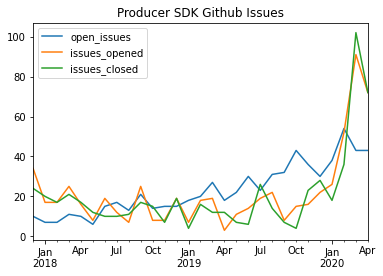

In [35]:
# nbi:hide_in
df_producer = get_df(FILENAME_PRODUCER_COUNTS)
df2 = df_producer[['open_issues', 'issues_opened', 'issues_closed']]
ax = df2.plot(title='Producer SDK Github Issues');


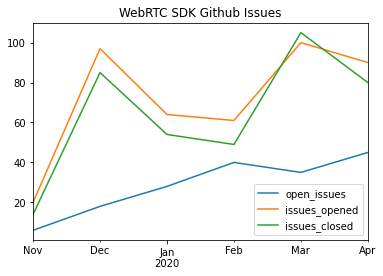

In [36]:
# nbi:hide_in
df_webrtc = get_df(FILENAME_WEBRTC_COUNTS)
df2 = df_webrtc[['open_issues', 'issues_opened', 'issues_closed']]
ax = df2.plot(title = 'WebRTC SDK Github Issues');


In [37]:
# nbi:hide_in
# nbi:hide_out
df=pd.read_csv(FILENAME_PRODUCER_COUNTS, parse_dates = ['date'])
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.rename(columns = {' total_issues':'total_issues', ' open_issues':'open_issues', 
                              ' closed_issue':'closed_issues'}, inplace = True) 
df = df.filter(['date','total_issues','open_issues','closed_issues'])

df.head()

,total_issues,open_issues,closed_issues
date,,,
2017-12-01,2,2,0
2017-12-02,4,3,1
2017-12-03,6,5,1
2017-12-04,8,7,1
2017-12-05,8,6,2


In [38]:
#HIDDEN
idx = pd.date_range(df.index[0], df.index[-1])
df = df.reindex(idx, fill_value=0)
df['Month_End'] = df.index.is_month_end
sample_df = df[df['Month_End'] == 1].copy()

In [39]:
# nbi:hide_in
df.tail()

,total_issues,open_issues,closed_issues,Month_End
2020-05-03,635,41,594,False
2020-05-04,637,38,599,False
2020-05-05,641,41,600,False
2020-05-06,644,42,602,False
2020-05-07,647,44,603,False


In [40]:
#HIDDEN
sample_df = sample_df.drop(['Month_End'], axis=1)
sample_df.head()


,total_issues,open_issues,closed_issues
2017-12-31,34,10,24
2018-01-31,51,7,44
2018-02-28,68,7,61
2018-03-31,93,11,82
2018-04-30,109,10,99


In [41]:
#HIDDEN
sLength = len(sample_df['total_issues'])
#print(sLength)
issues_opened =  pd.Series(np.zeros(sLength))
issues_closed =  pd.Series(np.zeros(sLength))
sample_df = sample_df.assign(issues_opened=issues_opened.values)
sample_df = sample_df.assign(issues_closed=issues_closed.values)
sample_df.head()

#sample_df = sample_df.assign('issues_opened'=pd.Series(np.zeros(sLength)).values)
#sample_df.loc[:,'issues_opened'] = pd.Series(np.zeros(sLength), index=sample_df.index)
#sample_df.loc[:,'issues_closed'] = pd.Series(np.zeros(sLength), index=sample_df.index)



,total_issues,open_issues,closed_issues,issues_opened,issues_closed
2017-12-31,34,10,24,0.0,0.0
2018-01-31,51,7,44,0.0,0.0
2018-02-28,68,7,61,0.0,0.0
2018-03-31,93,11,82,0.0,0.0
2018-04-30,109,10,99,0.0,0.0


In [42]:
#HIDDEN
sample_df['issues_opened'] = sample_df.total_issues.shift().fillna(0) 
sample_df['issues_closed'] = sample_df.closed_issues.shift().fillna(0) 

sample_df['issues_opened'] = sample_df['total_issues'] - sample_df['issues_opened']
sample_df['issues_closed'] = sample_df['closed_issues'] - sample_df['issues_closed']

sample_df.head()

#sample

,total_issues,open_issues,closed_issues,issues_opened,issues_closed
2017-12-31,34,10,24,34.0,24.0
2018-01-31,51,7,44,17.0,20.0
2018-02-28,68,7,61,17.0,17.0
2018-03-31,93,11,82,25.0,21.0
2018-04-30,109,10,99,16.0,17.0


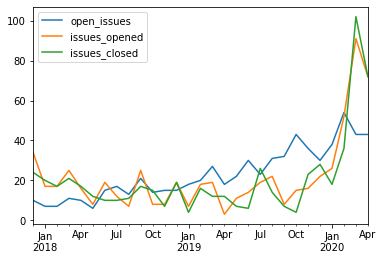

In [43]:
# nbi:hide_in
df2 = sample_df[['open_issues', 'issues_opened', 'issues_closed']]
df2.plot();